In [252]:
! pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [253]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import ipyvolume as ipv
import umap
import matplotlib.cm as cm


from sklearn.metrics import pairwise_distances, silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import trustworthiness
from sklearn.ensemble import RandomForestRegressor
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

# Tentative d'interprétation visuelle

In [254]:
data = pd.read_table("./heart.csv", sep=",")
data.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [255]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

In [256]:
data.corr(numeric_only=True)

Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  \
Age           1.000000   0.254399    -0.095282   0.198039 -0.382045  0.258612   
RestingBP     0.254399   1.000000     0.100893   0.070193 -0.112135  0.164803   
Cholesterol  -0.095282   0.100893     1.000000  -0.260974  0.235792  0.050148   
FastingBS     0.198039   0.070193    -0.260974   1.000000 -0.131438  0.052698   
MaxHR        -0.382045  -0.112135     0.235792  -0.131438  1.000000 -0.160691   
Oldpeak       0.258612   0.164803     0.050148   0.052698 -0.160691  1.000000   
HeartDisease  0.282039   0.107589    -0.232741   0.267291 -0.400421  0.403951   

              HeartDisease  
Age               0.282039  
RestingBP         0.107589  
Cholesterol      -0.232741  
FastingBS         0.267291  
MaxHR            -0.400421  
Oldpeak           0.403951  
HeartDisease      1.000000

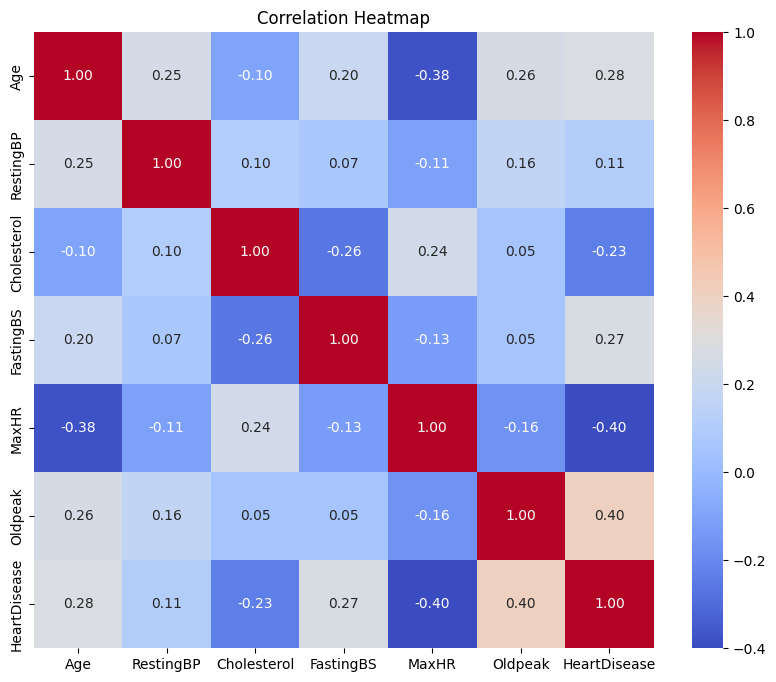

In [257]:
numeric_data = data.select_dtypes(include=["number"])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

<Figure size 2000x2000 with 0 Axes>

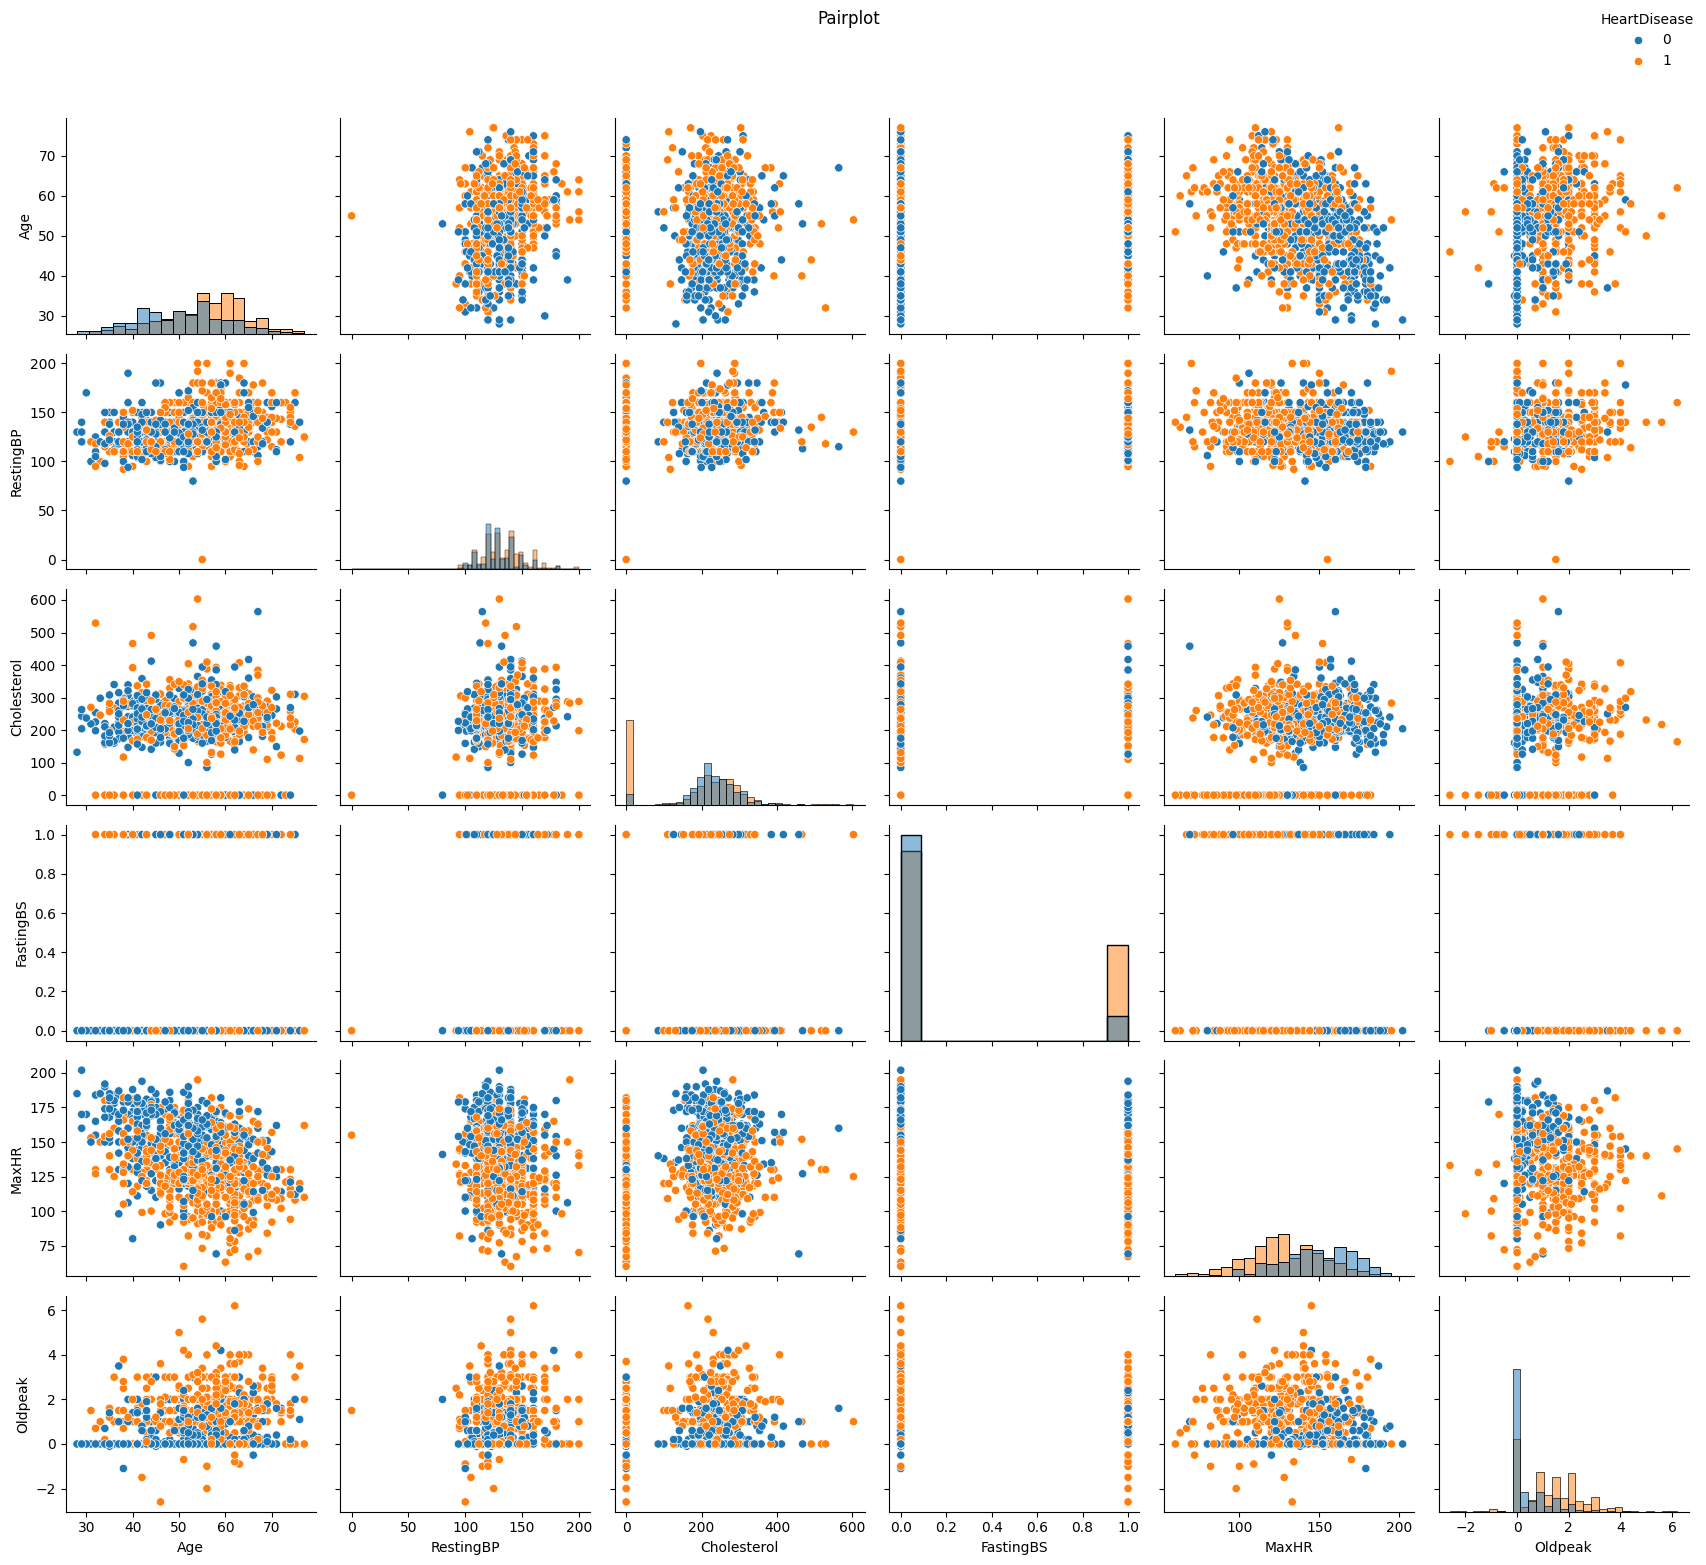

In [258]:
cols = data.columns.tolist()

fig = plt.figure(figsize = (20,20))
g = sns.pairplot(data=data[cols], hue=cols[-1], diag_kind='hist')
g.figure.suptitle('Pairplot', y=1.04)
g._legend.remove() 
g.add_legend(loc='upper right')
plt.tight_layout()

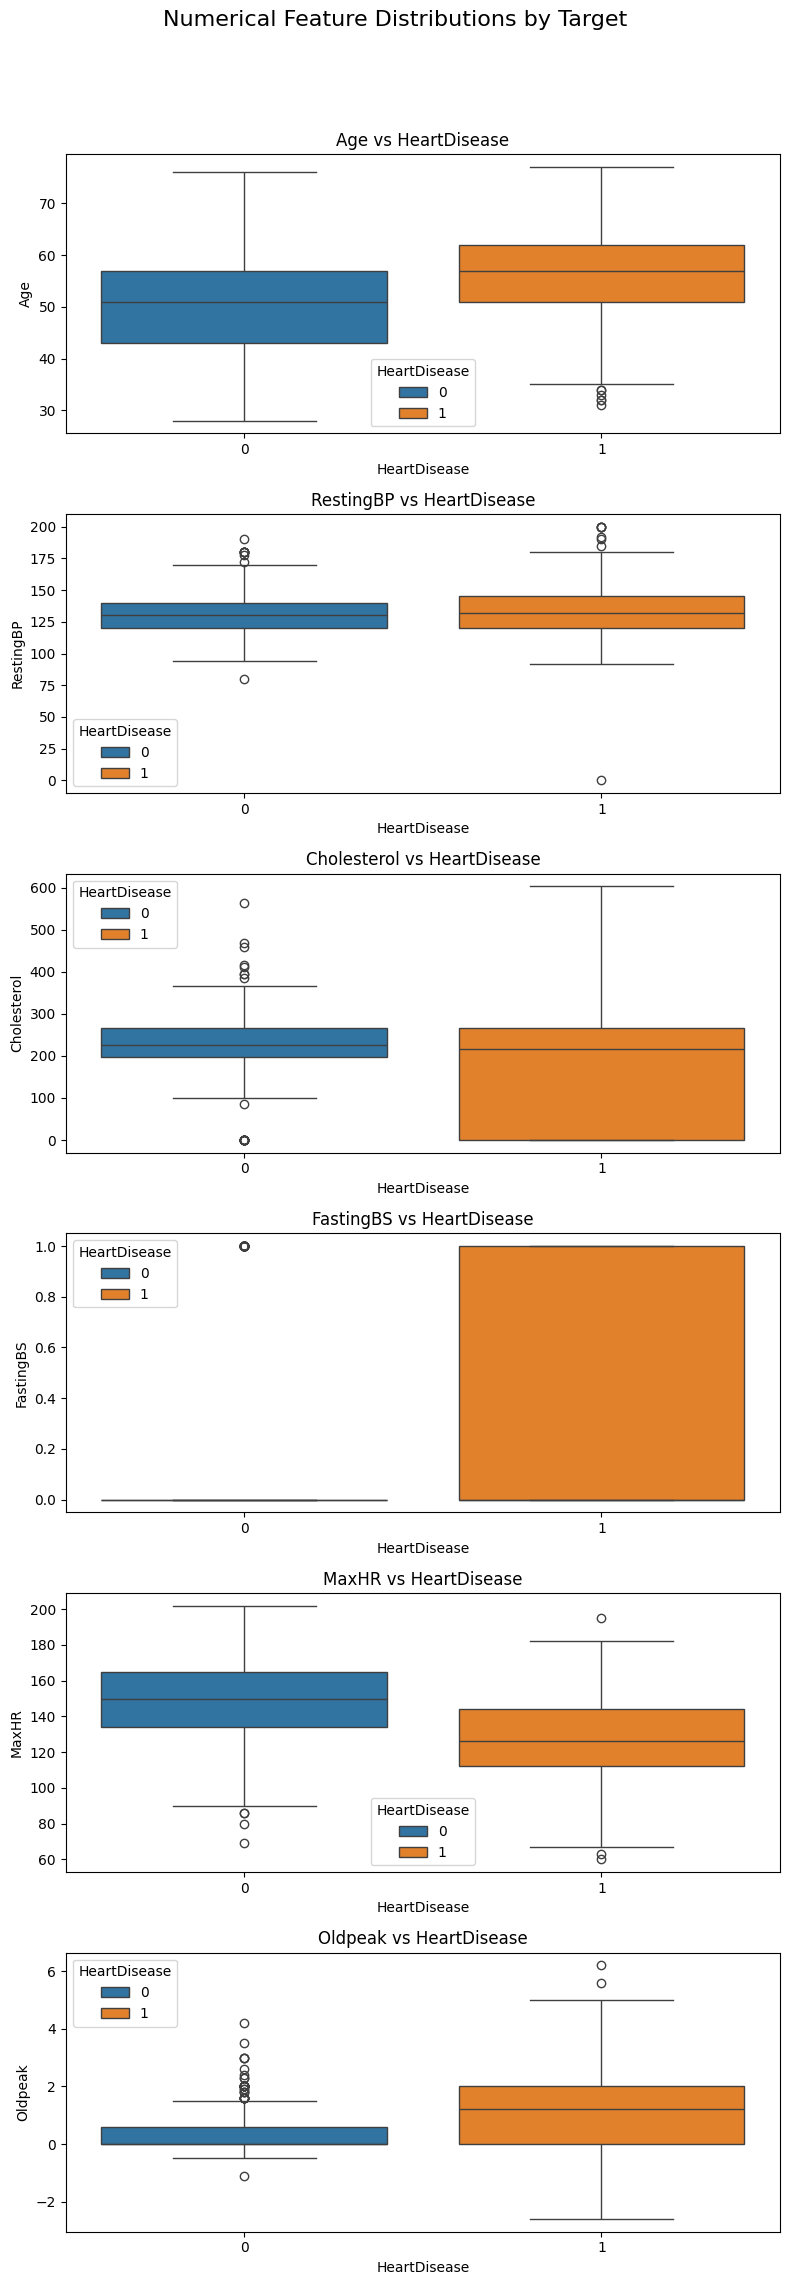

In [259]:
numerical_features = data.select_dtypes(include='number').drop(columns=cols[-1]).columns

n = len(numerical_features)
fig, axes = plt.subplots(n, 1, figsize=(8, 4 * n))

fig.suptitle('Numerical Feature Distributions by Target', fontsize=16)

for ax, feature in zip(axes, numerical_features):
    sns.boxplot(data=data, x=cols[-1], y=feature, ax=ax, hue=cols[-1])
    ax.set_title(f'{feature} vs {cols[-1]}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [260]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder


data_transformed = data.copy()

cat_cols = data_transformed.select_dtypes(include="object").columns
print("Colonnes catégorielles détectées :", list(cat_cols))

enc = OrdinalEncoder()
data_transformed[cat_cols] = enc.fit_transform(data_transformed[cat_cols])

print("\n Correspondance modalités / codes")
for col, cats in zip(cat_cols, enc.categories_):
    mapping = {cat: int(code) for code, cat in enumerate(cats)}
    print(f"{col}: {mapping}")


Colonnes catégorielles détectées : ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

 Correspondance modalités / codes
Sex: {'F': 0, 'M': 1}
ChestPainType: {'ASY': 0, 'ATA': 1, 'NAP': 2, 'TA': 3}
RestingECG: {'LVH': 0, 'Normal': 1, 'ST': 2}
ExerciseAngina: {'N': 0, 'Y': 1}
ST_Slope: {'Down': 0, 'Flat': 1, 'Up': 2}


In [ ]:
#pos = len(data_transformed.columns) - 1
#data_transformed.insert(pos, "Duplicat", data_transformed[cols[-1]])  

In [ ]:

last_col = data_transformed.columns[-1]

mask = data_transformed[last_col] == 1

rand_vals = np.empty(len(df), dtype=int)
rand_vals[mask]  = np.random.randint(4, 7, size=mask.sum())
rand_vals[~mask] = np.random.randint(1, 4, size=(~mask).sum())

pos = len(data_transformed.columns) - 1
data_transformed.insert(pos, "Random_Cond", rand_vals)


In [262]:
data_transformed.head()

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40  1.0            1.0        140          289          0         1.0   
1   49  0.0            2.0        160          180          0         1.0   
2   37  1.0            1.0        130          283          0         2.0   
3   48  0.0            0.0        138          214          0         1.0   
4   54  1.0            2.0        150          195          0         1.0   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  Duplicat  HeartDisease  
0    172             0.0      0.0       2.0         0             0  
1    156             0.0      1.0       1.0         1             1  
2     98             0.0      0.0       2.0         0             0  
3    108             1.0      1.5       1.0         1             1  
4    122             0.0      0.0       2.0         0             0

In [263]:
data_transformed.info()
data_transformed.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    float64
 2   ChestPainType   918 non-null    float64
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    float64
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    float64
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    float64
 11  Duplicat        918 non-null    int64  
 12  HeartDisease    918 non-null    int64  
dtypes: float64(6), int64(7)
memory usage: 93.4 KB


Age         Sex  ChestPainType   RestingBP  Cholesterol  \
count  918.000000  918.000000     918.000000  918.000000   918.000000   
mean    53.510893    0.789760       0.781046  132.396514   198.799564   
std      9.432617    0.407701       0.956519   18.514154   109.384145   
min     28.000000    0.000000       0.000000    0.000000     0.000000   
25%     47.000000    1.000000       0.000000  120.000000   173.250000   
50%     54.000000    1.000000       0.000000  130.000000   223.000000   
75%     60.000000    1.000000       2.000000  140.000000   267.000000   
max     77.000000    1.000000       3.000000  200.000000   603.000000   

        FastingBS  RestingECG       MaxHR  ExerciseAngina     Oldpeak  \
count  918.000000  918.000000  918.000000      918.000000  918.000000   
mean     0.233115    0.989107  136.809368        0.404139    0.887364   
std      0.423046    0.631671   25.460334        0.490992    1.066570   
min      0.000000    0.000000   60.000000        0.000000   -2.600000   
25%      0.000000    1.000000  120.000000        0.000000    0.000000   
50%      0.000000    1.000000  138.000000        0.000000    0.600000   
75%      0.000000    1.000000  156.000000        1.000000    1.500000   
max      1.000000    2.000000  202.000000        1.000000    6.200000   

         ST_Slope    Duplicat  HeartDisease  
count  918.000000  918.000000    918.000000  
mean     1.361656    0.553377      0.553377  
std      0.607056    0.497414      0.497414  
min      0.000000    0.000000      0.000000  
25%      1.000000    0.000000      0.000000  
50%      1.000000    1.000000      1.000000  
75%      2.000000    1.000000      1.000000  
max      2.000000    1.000000      1.000000

In [264]:
data_transformed.corr()

Age       Sex  ChestPainType  RestingBP  Cholesterol  \
Age             1.000000  0.055750      -0.077150   0.254399    -0.095282   
Sex             0.055750  1.000000      -0.126559   0.005133    -0.200092   
ChestPainType  -0.077150 -0.126559       1.000000  -0.020647     0.067880   
RestingBP       0.254399  0.005133      -0.020647   1.000000     0.100893   
Cholesterol    -0.095282 -0.200092       0.067880   0.100893     1.000000   
FastingBS       0.198039  0.120076      -0.073151   0.070193    -0.260974   
RestingECG     -0.007484  0.071552      -0.072537   0.022656    -0.196544   
MaxHR          -0.382045 -0.189186       0.289123  -0.112135     0.235792   
ExerciseAngina  0.215793  0.190664      -0.354727   0.155101    -0.034166   
Oldpeak         0.258612  0.105734      -0.177377   0.164803     0.050148   
ST_Slope       -0.268264 -0.150693       0.213521  -0.075162     0.111471   
Duplicat        0.282039  0.305445      -0.386828   0.107589    -0.232741   
HeartDisease    0.282039  0.305445      -0.386828   0.107589    -0.232741   

                FastingBS  RestingECG     MaxHR  ExerciseAngina   Oldpeak  \
Age              0.198039   -0.007484 -0.382045        0.215793  0.258612   
Sex              0.120076    0.071552 -0.189186        0.190664  0.105734   
ChestPainType   -0.073151   -0.072537  0.289123       -0.354727 -0.177377   
RestingBP        0.070193    0.022656 -0.112135        0.155101  0.164803   
Cholesterol     -0.260974   -0.196544  0.235792       -0.034166  0.050148   
FastingBS        1.000000    0.087050 -0.131438        0.060451  0.052698   
RestingECG       0.087050    1.000000 -0.179276        0.077500 -0.020438   
MaxHR           -0.131438   -0.179276  1.000000       -0.370425 -0.160691   
ExerciseAngina   0.060451    0.077500 -0.370425        1.000000  0.408752   
Oldpeak          0.052698   -0.020438 -0.160691        0.408752  1.000000   
ST_Slope        -0.175774   -0.006778  0.343419       -0.428706 -0.501921   
Duplicat         0.267291    0.057384 -0.400421        0.494282  0.403951   
HeartDisease     0.267291    0.057384 -0.400421        0.494282  0.403951   

                ST_Slope  Duplicat  HeartDisease  
Age            -0.268264  0.282039      0.282039  
Sex            -0.150693  0.305445      0.305445  
ChestPainType   0.213521 -0.386828     -0.386828  
RestingBP      -0.075162  0.107589      0.107589  
Cholesterol     0.111471 -0.232741     -0.232741  
FastingBS      -0.175774  0.267291      0.267291  
RestingECG     -0.006778  0.057384      0.057384  
MaxHR           0.343419 -0.400421     -0.400421  
ExerciseAngina -0.428706  0.494282      0.494282  
Oldpeak        -0.501921  0.403951      0.403951  
ST_Slope        1.000000 -0.558771     -0.558771  
Duplicat       -0.558771  1.000000      1.000000  
HeartDisease   -0.558771  1.000000      1.000000

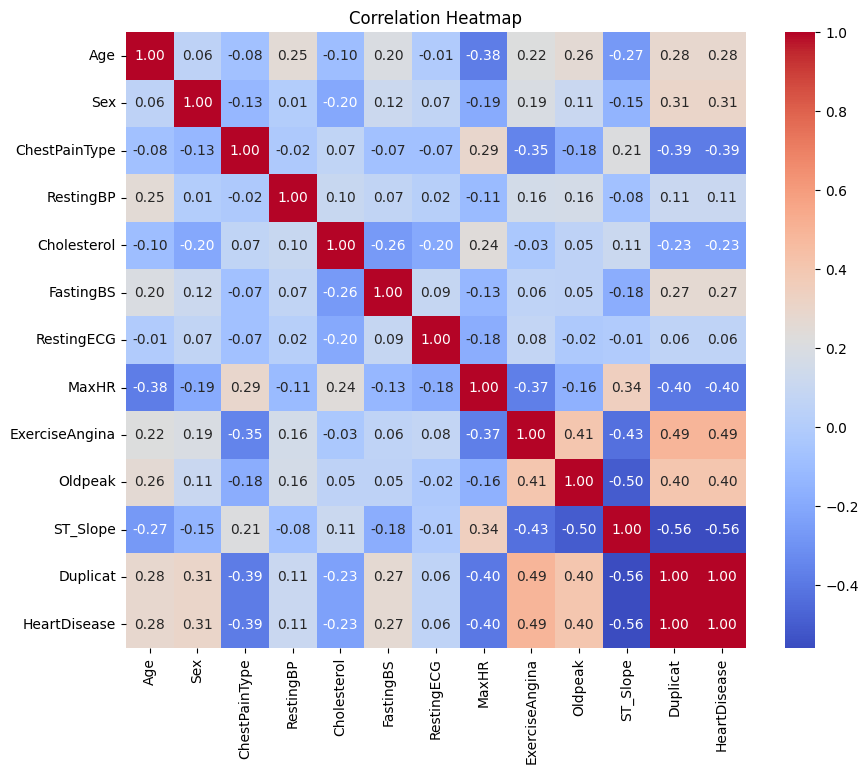

In [265]:
numeric_data_transformed = data_transformed.select_dtypes(include='number')

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data_transformed.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

<Figure size 2000x2000 with 0 Axes>

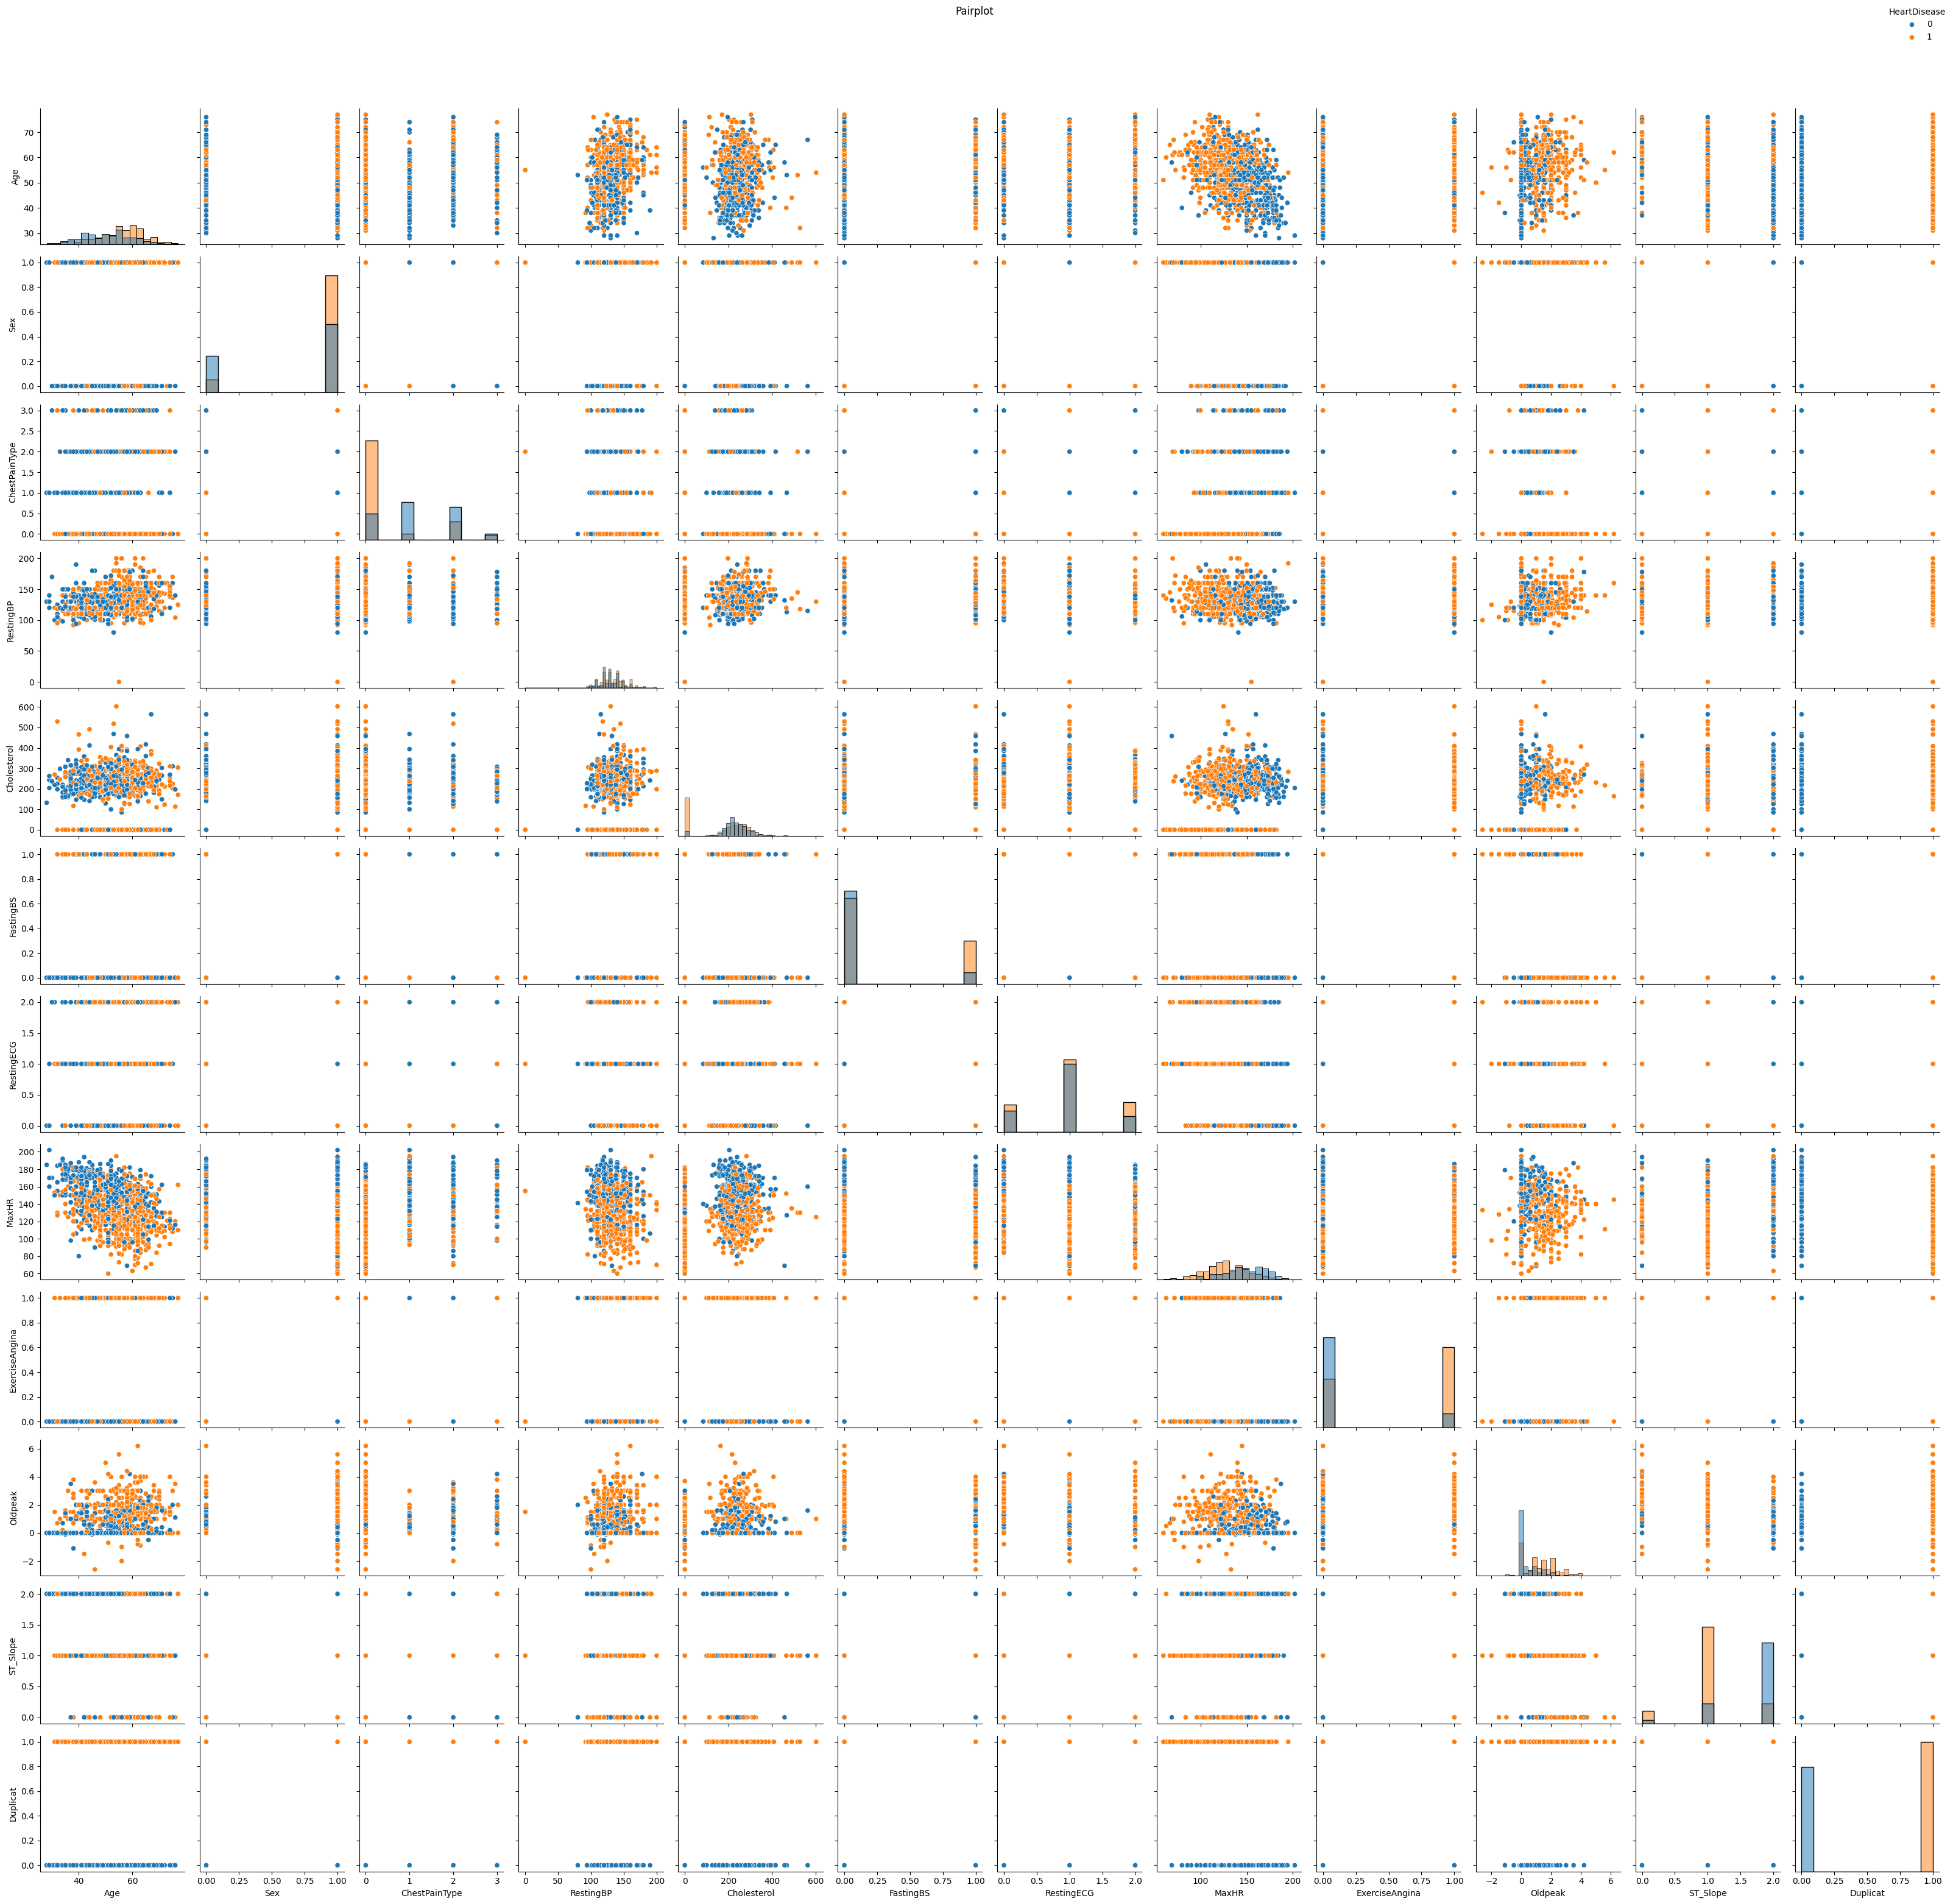

In [266]:
cols = data_transformed.columns.tolist()


fig = plt.figure(figsize = (20,20))
g = sns.pairplot(data=data_transformed[cols], hue=cols[-1], diag_kind='hist')
g.figure.suptitle('Pairplot', y=1.04)
g._legend.remove() 
g.add_legend(loc='upper right')
plt.tight_layout()

# PCA

In [267]:
X = data_transformed.iloc[:, :-1]
y = data_transformed.iloc[:, -1]

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [269]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

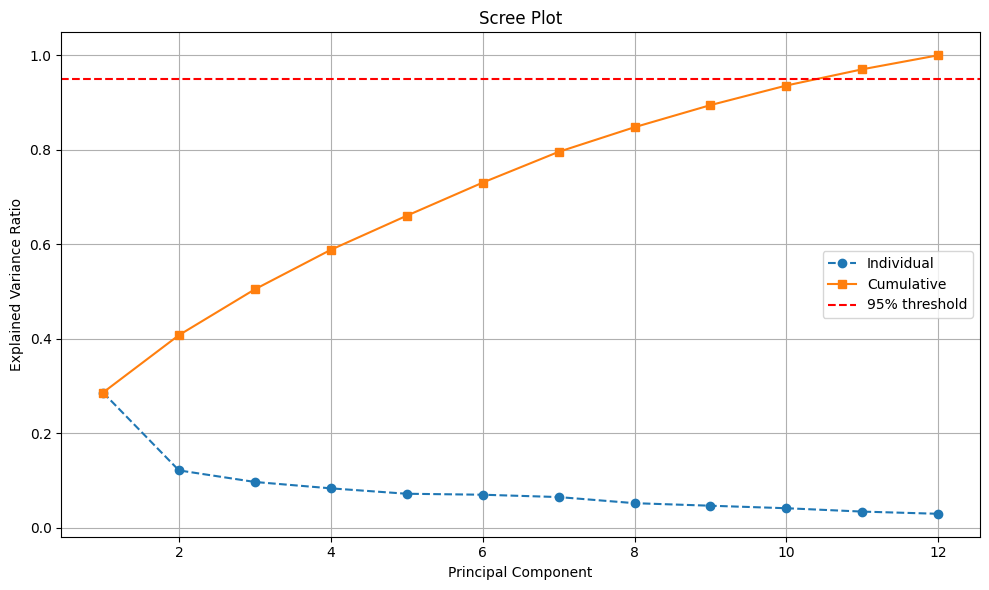

Number of principal components needed to retain at least 95% variance: 11


In [270]:
# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', linestyle='--', label='Individual')
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='s', linestyle='-', label='Cumulative')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Decision rule: number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of principal components needed to retain at least 95% variance: {n_components_95}")


In [271]:
for i, var in enumerate(explained_variance, 1):
    print(f"PC{i}: {var:.4f}")

PC1: 0.2863
PC2: 0.1215
PC3: 0.0970
PC4: 0.0836
PC5: 0.0721
PC6: 0.0701
PC7: 0.0651
PC8: 0.0522
PC9: 0.0468
PC10: 0.0415
PC11: 0.0343
PC12: 0.0297


In [272]:
pca = PCA(n_components=n_components_95)
pca.fit(X_train)

PCA(n_components=11)

In [273]:
# PCA loadings: each column corresponds to a principal component
loadings = pd.DataFrame(
    data=pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=X.columns
)
print(loadings)

                     PC1       PC2       PC3       PC4       PC5       PC6  \
Age             0.285758  0.090711  0.533779  0.018175 -0.068459 -0.220450   
Sex             0.222357 -0.254193 -0.194284 -0.056642  0.688929  0.446396   
ChestPainType  -0.257022 -0.030683  0.437874 -0.247098 -0.185680  0.538197   
RestingBP       0.154783  0.241324  0.540481  0.385378  0.398531  0.120412   
Cholesterol    -0.164579  0.599452 -0.043230  0.164612  0.087809  0.029484   
FastingBS       0.185884 -0.351592  0.351306 -0.392311  0.065595 -0.136059   
RestingECG      0.084224 -0.409828 -0.001878  0.611626 -0.398065  0.395440   
MaxHR          -0.352252  0.154097 -0.054008 -0.274453  0.086176  0.323311   
ExerciseAngina  0.381430  0.179338 -0.206303  0.166428  0.016261  0.021437   
Oldpeak         0.318154  0.376786 -0.035489 -0.138012 -0.229293  0.377086   
ST_Slope       -0.384559 -0.138300  0.061100  0.284911  0.310185 -0.157768   
Duplicat        0.437573 -0.007525 -0.133123 -0.168974  0.020885

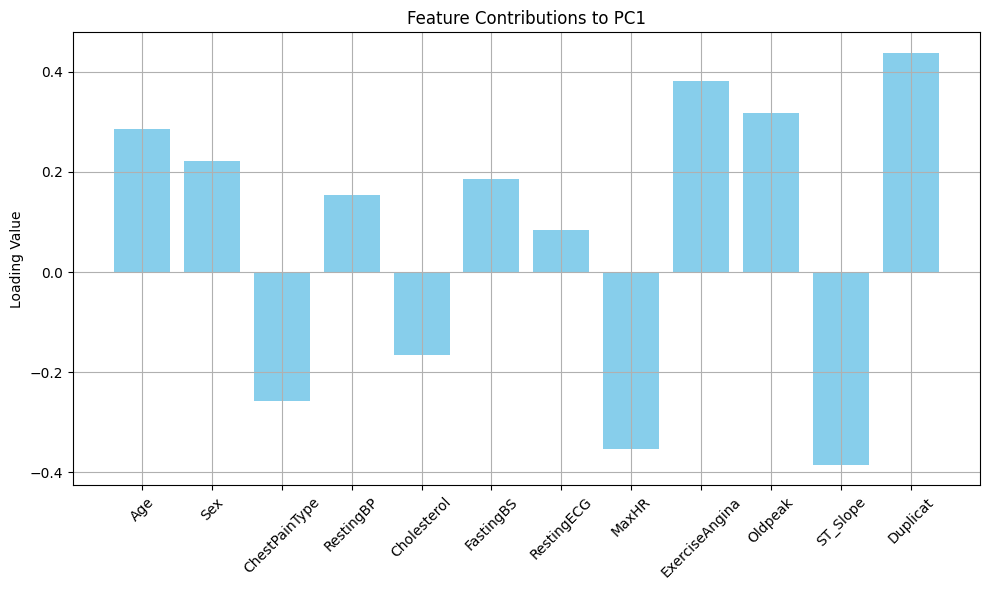

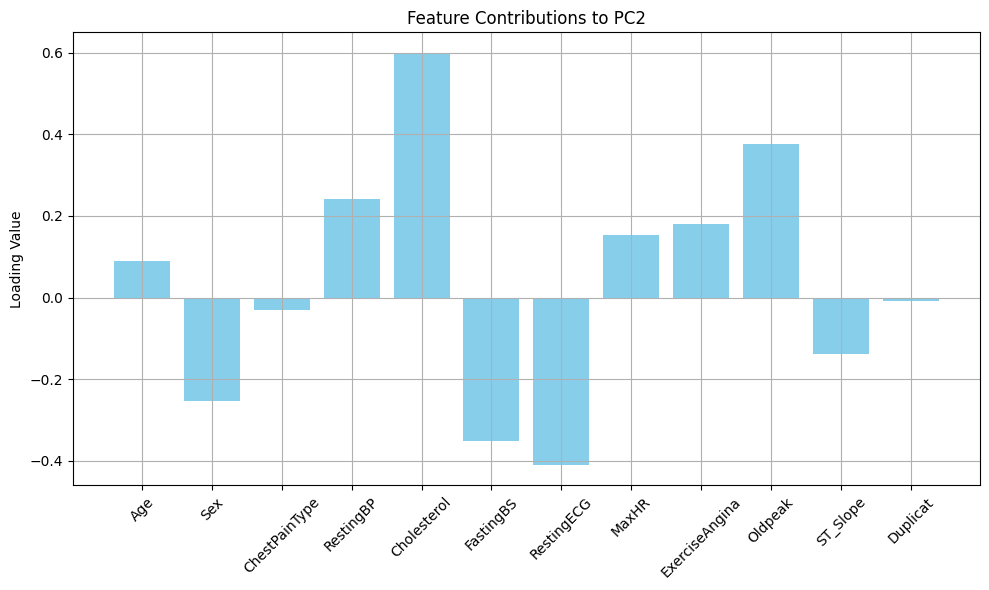

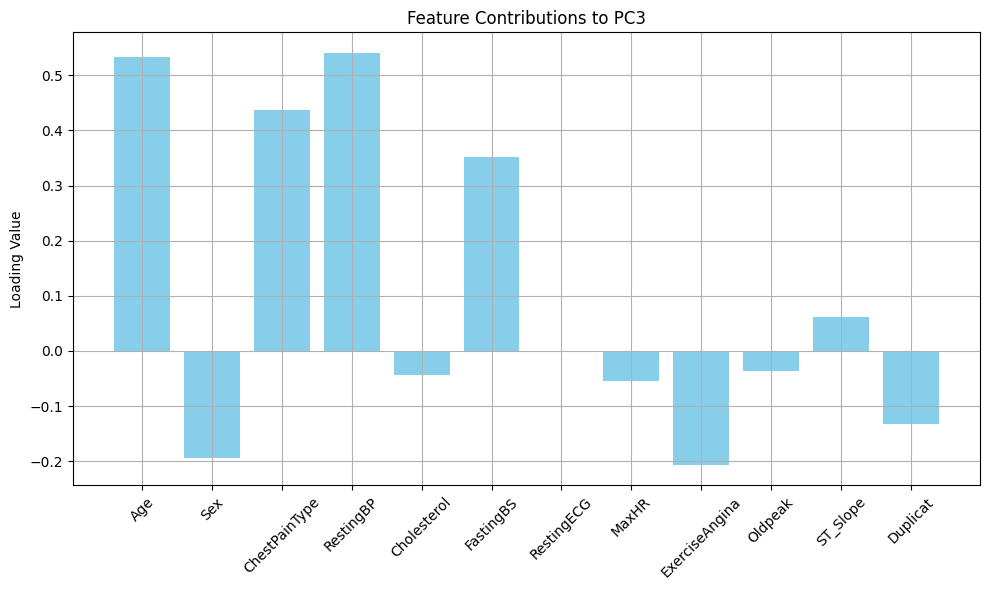

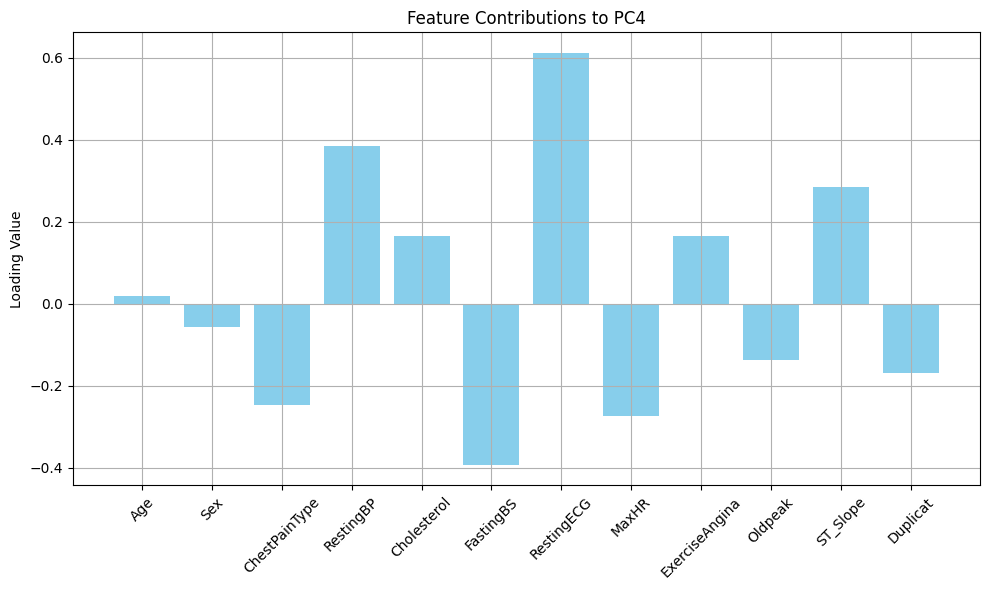

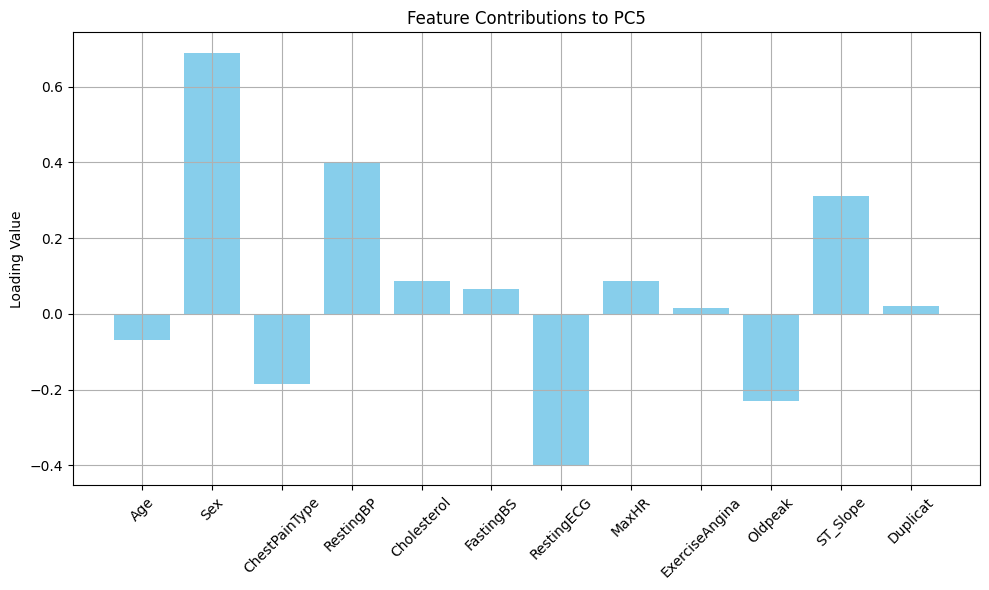

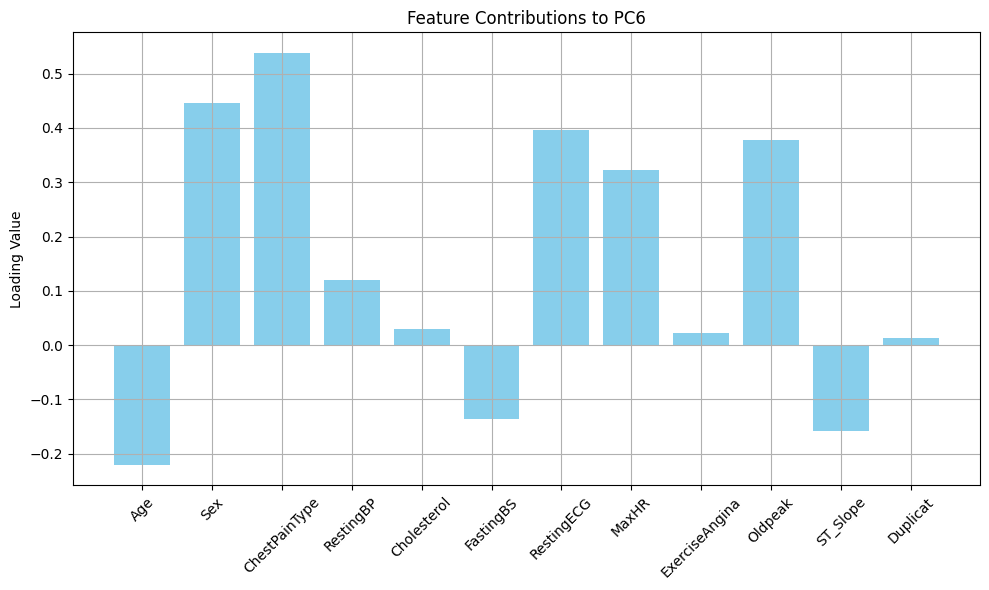

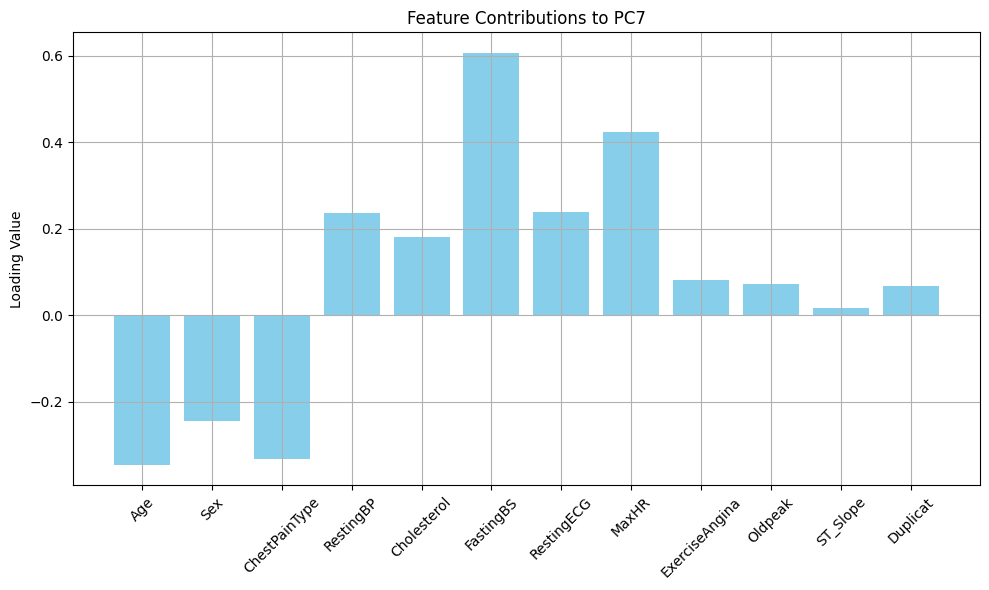

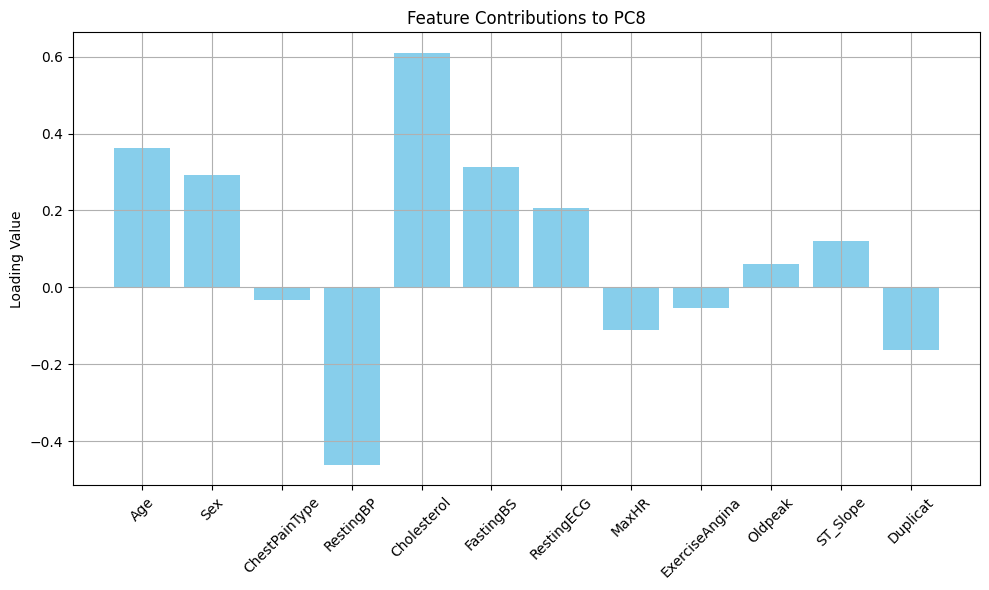

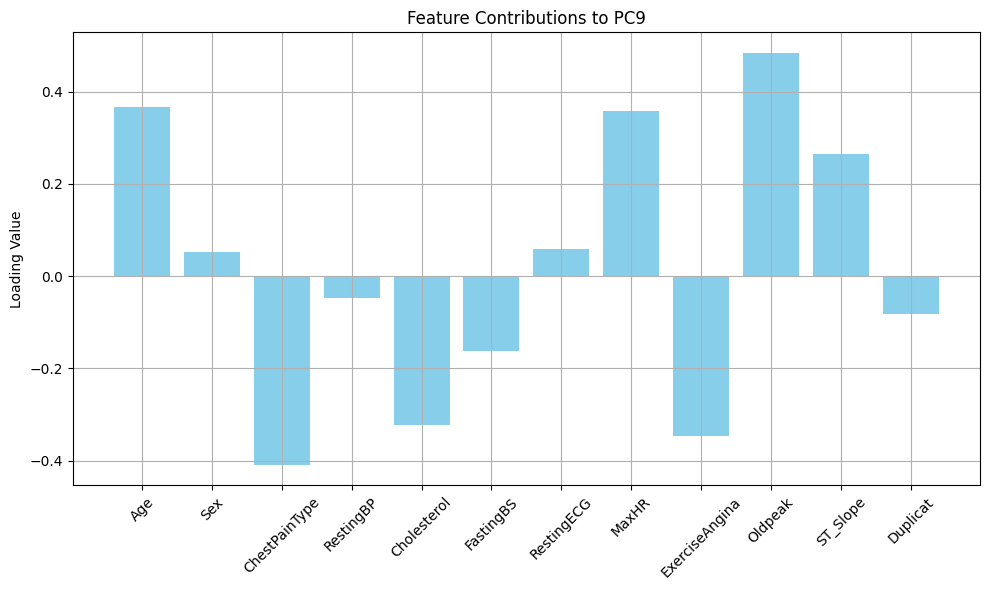

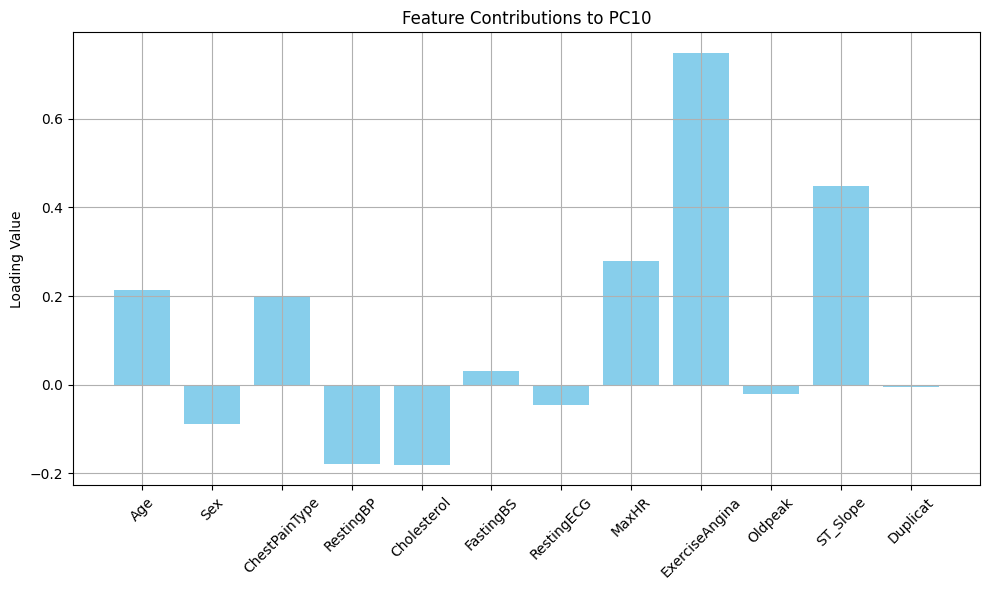

In [274]:
for i in range(10):
    pc = f'PC{i+1}'
    plt.figure(figsize=(10, 6))
    plt.bar(loadings.index, loadings[pc], color='skyblue')
    plt.title(f'Feature Contributions to {pc}')
    plt.ylabel('Loading Value')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

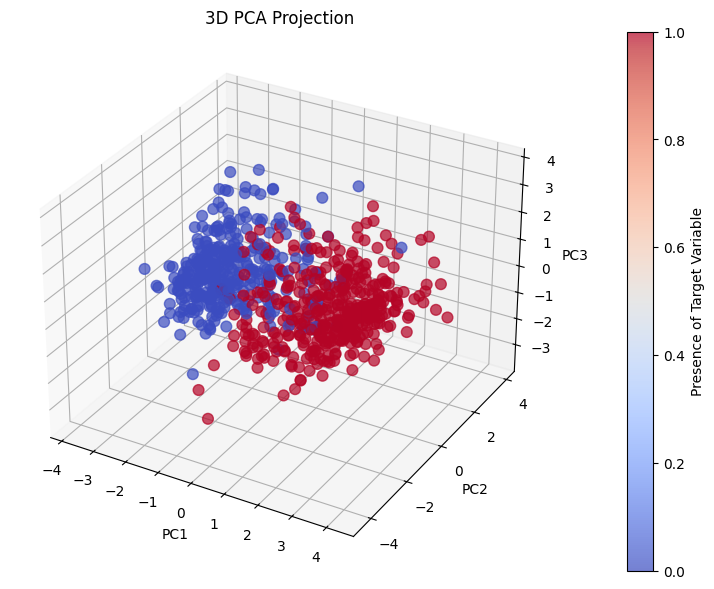

In [275]:
# Reduce to 3 components
pca_3d = PCA(n_components=3)
X_train_3d = pca_3d.fit_transform(X_train)

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Use target (y_train) as color
scatter = ax.scatter(X_train_3d[:, 0], X_train_3d[:, 1], X_train_3d[:, 2],
                     c=y_train, cmap='coolwarm', alpha=0.7, s=60)

ax.set_title('3D PCA Projection')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Add color bar
legend = fig.colorbar(scatter, ax=ax, pad=0.1)
legend.set_label('Presence of Target Variable')

plt.show()


In [276]:
def visualize_3d(x, labels):
    # Normalize coordinates
    x_norm = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))
    x_vals, y_vals, z_vals = x_norm[:, 0], x_norm[:, 1], x_norm[:, 2]

    # Ensure labels are 0 and 1 integers
    labels = np.array(labels).astype(int)

    # Build color array from colormap
    cmap = plt.get_cmap('coolwarm')
    color_map = np.array([cmap(0), cmap(1)])  # map 0 -> one color, 1 -> another
    label_colors = color_map[labels]  # now colors are correctly assigned

    # Plot
    ipv.figure(width=600, height=500)
    ipv.scatter(x_vals, y_vals, z_vals, size=4, color=label_colors, marker='sphere')
    ipv.xyzlim(0, 1)
    ipv.show()

    
pca = PCA(n_components=3)
X_pca3 = pca.fit_transform(X_train)

visualize_3d(X_pca3, y_train.values)


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [277]:
def visualize_3d_plotly(x, labels):
    """
    3D scatter plot with Plotly, colored by HeartDisease (0 or 1).
    """
    df = pd.DataFrame(x, columns=["PC1", "PC2", "PC3"])
    df[cols[-1]] = labels

    fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3",
                        color=df[cols[-1]].astype(str),
                        color_discrete_map={"0": "blue", "1": "red"},
                        title="3D PCA Colored by Traget Variable",)
    fig.show()

visualize_3d_plotly(X_pca3, y_train.values)

# UMAP

/Users/mathisbonkoungou/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/mathisbonkoungou/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/mathisbonkoungou/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/mathisbonkoungou/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/mathisbonkoungou/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/mathisbonkoungou/Library/Python/3.9/lib/python/site-p

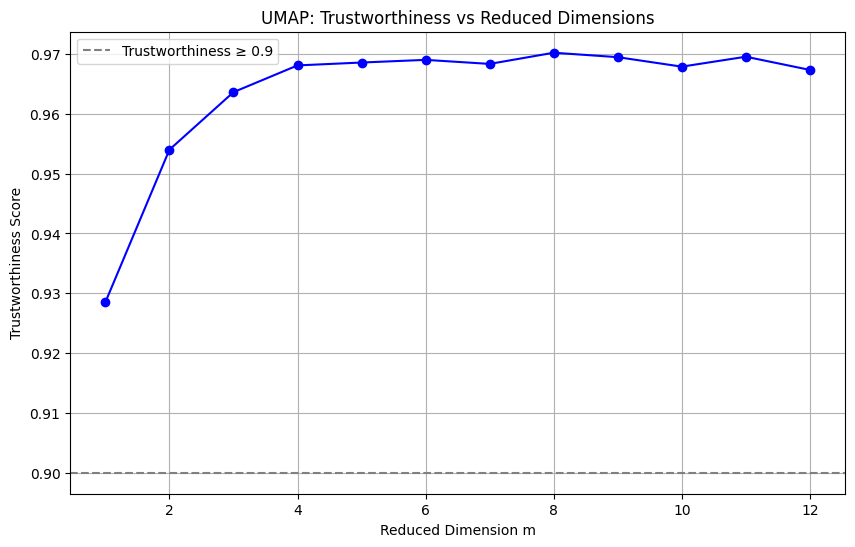

Best embedding dimension m = 2 (trustworthiness = 0.954)


In [278]:
# Scale input
X_scaled = scaler.fit_transform(X)

# Evaluate trustworthiness across dimensions
dims = list(range(1, X.shape[1] + 1))
umap_trust = []

for m in dims:
    reducer = umap.UMAP(n_components=m, random_state=42)
    X_umap = reducer.fit_transform(X_scaled)
    score = trustworthiness(X_scaled, X_umap, n_neighbors=15)
    umap_trust.append(score)


plt.figure(figsize=(10, 6))
plt.plot(dims, umap_trust, marker='o', color='blue')
plt.axhline(y=0.9, linestyle='--', color='gray', label='Trustworthiness ≥ 0.9')
plt.title('UMAP: Trustworthiness vs Reduced Dimensions')
plt.xlabel('Reduced Dimension m')
plt.ylabel('Trustworthiness Score')
plt.grid(True)
plt.legend()
plt.show()



for i, score in enumerate(umap_trust):
    if score >= 0.95:
        print(f"Best embedding dimension m = {dims[i]} (trustworthiness = {score:.3f})")
        break

m = dims[i]

In [279]:
# Données et réduction
reducer = umap.UMAP(n_components=m, random_state=42)
X_umap  = reducer.fit_transform(X_scaled)


# Corrélations
umap_df = pd.DataFrame(X_umap, columns=[f'UMAP{i+1}' for i in range(m)])
corr    = pd.concat([X, umap_df], axis=1).corr().loc[X.columns, umap_df.columns]


pd.set_option("display.max_columns", None)
print("\nMatrice de corrélation variables  ↔  axes UMAP :\n")
print(corr.round(3).to_string())

/Users/mathisbonkoungou/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




Matrice de corrélation variables  ↔  axes UMAP :

                UMAP1  UMAP2
Age            -0.052 -0.308
Sex            -0.847  0.073
ChestPainType   0.180  0.363
RestingBP      -0.020 -0.068
Cholesterol     0.110  0.192
FastingBS       0.268 -0.306
RestingECG     -0.081 -0.042
MaxHR           0.230  0.377
ExerciseAngina -0.297 -0.551
Oldpeak        -0.178 -0.453
ST_Slope        0.181  0.548
Duplicat       -0.309 -0.703


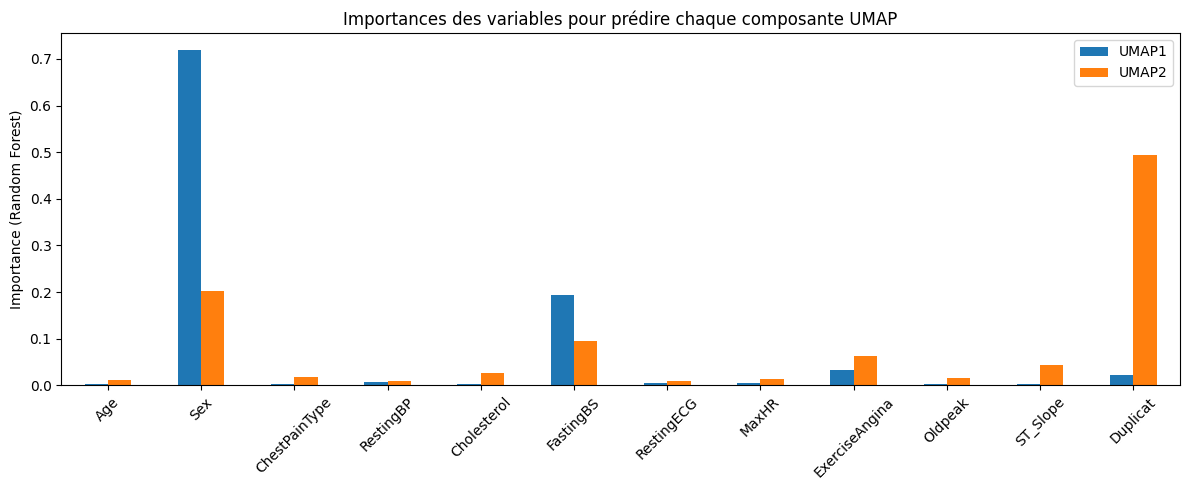

In [280]:
importances = pd.DataFrame(index=X.columns)

for i in range(m):
    rf = RandomForestRegressor(n_estimators=300, random_state=42)
    rf.fit(X, X_umap[:, i])
    importances[f'UMAP{i+1}'] = rf.feature_importances_

importances.plot.bar(figsize=(12, 5))
plt.title("Importances des variables pour prédire chaque composante UMAP")
plt.ylabel("Importance (Random Forest)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [281]:
n_labels   = y.nunique()              # nb d'étiquettes différentes
label_vals = sorted(y.unique())

print(f"Nombre d'étiquettes différentes dans y : {n_labels}")


# Clustering K‑means (k = n_labels)
k = n_labels                                   
kmeans  = KMeans(n_clusters=k, random_state=42)
labels  = kmeans.fit_predict(X_umap)             
centers = kmeans.cluster_centers_


# Tableau de contingence + proportions
ct = pd.crosstab(y, labels, rownames=['vrai label'], colnames=['cluster'])
print("\nMatrice de contingence (effectifs) :\n")
display(ct)


# Proportions : chaque colonne somme à 100 %
prop = ct.div(ct.sum(axis=0), axis=1) * 100
print("\nProportions (%) de chaque label dans chaque cluster :\n")
display(prop.style.format("{:.1f}").background_gradient(cmap="Blues"))


# a) Intra ‑ moyenne des distances par cluster
intra = {}
for c in np.unique(labels):
    pts = X_umap[labels == c]
    if len(pts) > 1:
        d = pairwise_distances(pts)
        intra[c] = d[np.triu_indices_from(d, k=1)].mean()
    else:
        intra[c] = 0
print("\nDistance intra-cluster moyenne :", {c: round(v,3) for c,v in intra.items()})


# b) Inter ‑ matrice des distances des centroïdes
inter = pairwise_distances(centers)
print("Distance inter-cluster (centroïdes) :")
display(pd.DataFrame(inter).round(3))


Nombre d'étiquettes différentes dans y : 2

Matrice de contingence (effectifs) :



cluster       0    1
vrai label          
0           148  262
1           200  308


Proportions (%) de chaque label dans chaque cluster :




Distance intra-cluster moyenne : {0: 4.522, 1: 4.22}
Distance inter-cluster (centroïdes) :


0       1
0   0.000  10.221
1  10.221   0.000

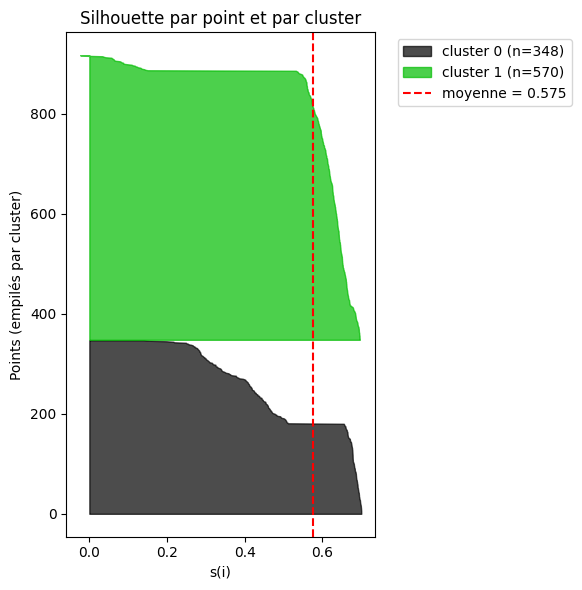

In [282]:
silhouette_vals = silhouette_samples(X_umap, labels)
silhouette_avg  = silhouette_score(X_umap, labels)

fig, ax = plt.subplots(figsize=(6, 6))
y_lower = 0
for c in np.unique(labels):

    sv = np.sort(silhouette_vals[labels == c])[::-1]
    n  = len(sv)
    y_upper = y_lower + n
    color = cm.nipy_spectral(float(c) / k)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, sv,
                     facecolor=color, edgecolor=color, alpha=0.7,
                     label=f"cluster {c} (n={n})")
    y_lower = y_upper

# ligne verticale = moyenne globale
ax.axvline(silhouette_avg, color="red", linestyle="--",
           label=f"moyenne = {silhouette_avg:.3f}")

ax.set_title("Silhouette par point et par cluster")
ax.set_xlabel("s(i)")
ax.set_ylabel("Points (empilés par cluster)")
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.tight_layout(); plt.show()


In [283]:

# DataFrame standardisé + infos cluster & label
X_std_df               = pd.DataFrame(X_scaled, columns=X.columns)
X_std_df["cluster"]    = labels
X_std_df["label"]      = y.values            # étiquette clinique


# Variance intra‑cluster
var_intra_clust = (X_std_df.groupby("cluster")
                               .var()
                               .T)

# Variance intra‑label
var_intra_label = (X_std_df.groupby("label")
                               .var()
                               .T)


print("\n Variance INTRA-CLUSTER")
display(var_intra_clust.round(3))


print("\n Variance INTRA-LABEL")
display(var_intra_label.round(3))


 Variance INTRA-CLUSTER


cluster             0      1
Age             0.991  0.991
Sex             1.496  0.021
ChestPainType   0.969  1.022
RestingBP       1.140  0.916
Cholesterol     1.332  0.789
FastingBS       1.399  0.288
RestingECG      1.082  0.949
MaxHR           0.975  1.018
ExerciseAngina  0.968  1.017
Oldpeak         0.906  1.059
ST_Slope        0.999  0.999
Duplicat        0.992  1.007
label           0.245  0.249


 Variance INTRA-LABEL


label               0      1
Age             1.004  0.857
Sex             1.371  0.535
ChestPainType   0.866  0.841
RestingBP       0.795  1.148
Cholesterol     0.466  1.337
FastingBS       0.537  1.248
RestingECG      0.871  1.102
MaxHR           0.838  0.845
ExerciseAngina  0.484  0.978
Oldpeak         0.431  1.168
ST_Slope        0.711  0.672
Duplicat        0.000  0.000
cluster         0.231  0.239